# Chapter 13 - Computational Performance

## 13.1. Compilers and Interpreters

Up to now, we have focused on *imperative programming*, which makes uses of statements such as `print`, `+`, and `if` to change a program's state. For example,

In [1]:
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)

    return g

print(fancy_func(1, 2, 3, 4))

10


Python is an *interpreted language*. When evaluating the above `fancy_func` function it performs the operations making up the function’s body *in sequence*, represented in the following figure.

![](../imgs/ch13/computegraph.svg)

Although imperative programming is convenient, it may be inefficient. The three `add` function calls in `fancy_func` need to be executed sequentially.

### 13.1.1. Symbolic Programming

In the *symbolic programming*, the computation is usually performed only once the process has been fully defined. This approach is commonly used in *deep learning* and *automatic differentiation*, and usually involves the following steps:
1. Define the operations to be executed.
2. Compile the operations into an executable program.
3. Provide the required inputs and call the compiled program for execution.

In this way, we can skip the Python interpreter for the actual computation, thus removing a performance bottleneck that can become significant on multiple fast GPUs paired with a single Python thread on a CPU. It can also release memory whenever a variable is no longer needed.

In [7]:
# example of using compile() to create a program on the fly
# symbolic programming
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
10


* Imperative programming is easier. When imperative programming is used in Python, the majority of the code is straightforward and easy to write. It is also easier to debug imperative programming code. This is because it is easier to obtain and print all relevant intermediate variable values, or use Python’s built-in debugging tools.
* Symbolic programming is more efficient and easier to port. Symbolic programming makes it easier to optimize the code during compilation, while also having the ability to port the program into a format independent of Python. This allows the program to be run in a non-Python environment, thus avoiding any potential performance issues related to the Python interpreter.

### 13.1.2. Hybrid Programming

## 13.1.3. Hybridizing the `Sequential` Class

In [1]:
import torch
import torch.nn as nn

from d2l import torch as d2l

In [2]:
# factory for networks
def get_net():
    net = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 2),
    )

    return net

In [3]:
x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[0.0150, 0.0135]], grad_fn=<AddmmBackward0>)

This is a regular workflow to construct a neural network and pass data through it.

By converting the model using `torch.jit.script` function, we are able to compile and optimize the computation in the MLP. The model's computation result remains unchanged.

In [4]:
net = torch.jit.script(net) # convert to torchscript
net(x)

tensor([[0.0150, 0.0135]], grad_fn=<AddmmBackward0>)

Once this happens, the network is optimized. This means that the execution time of the model's computation is reduced. This is because the Python interpreter is no longer needed to execute the model's computation. In addition, the optimized model can be exported to a format that is independent of Python, thus allowing the model to be run in a non-Python environment.

#### 13.1.3.1. Accerlation by Hybridization

We can compare the execution time to evaluate `net(x)` before and after hybridization.

In [5]:
class Benchmark:
    '''For measuring running time'''
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self
    
    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [8]:
# benchmarking
net = get_net() # no hybridization
with Benchmark('Without torchscript'):
    for i in range(100000):
        net(x)

net = torch.jit.script(net) # hybridization
with Benchmark('With torchscript'):
    for i in range(100000):
        net(x)

Without torchscript: 10.5680 sec
With torchscript: 8.4506 sec


After an `nn.Sequential` instance is scripted using the `torch.jit.script` function, computing performance is improved through the use of symbolic programming.

## 13.2. Asynchronous Computation

For PyTorch, by default, GPU operations are asynchronous. We we call a function that uses the GPU, the operations are enqueued to the particular device, but not necessarily executed until later. This allows us to execute more computations in parallel, including operations on the CPU or other GPUs.

In [9]:
import os
import subprocess
import numpy
import torch
from torch import nn

from d2l import torch as d2l

### 13.2.1. Asynchrony via Backend

Suppose that we want to generate a random matrix and multiply it.

In [10]:
device = d2l.try_gpu()
device

device(type='cuda', index=0)

In [11]:
# warmup for GPU computation
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

# benchmarking with NumPy
with d2l.Benchmark('NumPy'):
    for _ in range(100):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

# benchmarking with PyTorch
with d2l.Benchmark('PyTorch'):
    for _ in range(100):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

NumPy: 3.3680 sec
PyTorch: 0.0158 sec


NumPy dot product is executed on the CPU processor while PyTorch matrix multiplication is executed on GPU. By default, GPU operations are asynchronous in PyTorch. Forcing PyTorch to finish all computation prior to returning shows what happened previously: computation is being executed by the backend while the frontend returns control to Python.

In [12]:
with d2l.Benchmark('GPU Synchronization'):
    for _ in range(100):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device=device)

GPU Synchronization: 0.2012 sec


PyTorch has a frontend for direct interaction with the users, e.g., via Python, as well as a backend used by the system to perform the computation.

Users can write PyTorch programs in various forntend languages, such as Python and C++. Regardless of the frontend programming language used, the execution of PyTorch programs occurs primarily in the backend of C++ implementations. The backend manages its own threads that continuously collect and execute queued tasks.

In [13]:
# dependency graph
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

![](../imgs/ch13/computegraph.svg)

The figure above shows the computational graph of the code snippet. The figure below shows how frontend and backend interact for this code snippet.

![](../imgs/ch13/threading.svg)

When the last statement’s results need to be printed, the Python frontend thread will wait for the C++ backend thread to finish computing the result of the variable `z`. 

## 13.3. Automatic Parallelism

Typically, a single operator will use all the computational resources on all CPUs or on a single GPU. 

While parallelization is typically most relevant between multiple GPUs, adding the local CPU will increase performance slightly. 

In [18]:
import torch

from d2l import torch as d2l

### 13.3.1. Parallel Computation on GPUs

Test case:
* the `run` function below performs 10 matrix-matrix multiplications on the device using data allocated into two variables: `x_cpu` and `x_gpu`.

In [19]:
device_gpu = d2l.try_gpu()
device_cpu = torch.device('cpu')
device_cpu, device_gpu

(device(type='cpu'), device(type='cuda', index=0))

In [20]:
def run(x):
    return [x.mm(x) for _ in range(50)]

In [21]:
# cpu
x_cpu = torch.rand(size=(4000, 4000), device=device_cpu)
# gpu
x_gpu = torch.rand(size=(4000, 4000), device=device_gpu)

Now we apply the function to the data. To ensure that caching does not play a role in the results we warm up the devices by performing a single pass on either of them prior to measuring. `torch.cuda.synchronize()` waits for all kernels in all streams on a CUDA device to complete. It takes in a `device` argument, the device for which we need to synchronize. It uses the current device, given by `current_device()`, if the device argument is None (default).

In [22]:
# warmup all devices
run(x_cpu)
run(x_gpu)
torch.cuda.synchronize(device_gpu)

with d2l.Benchmark('CPU Time'):
    run(x_cpu)

with d2l.Benchmark('GPU Time'):
    run(x_gpu)
    torch.cuda.synchronize(device_gpu)

CPU Time: 20.5477 sec
GPU Time: 3.1646 sec


If we remove the `synchronize` statement between both tasks, the system is free to paralleize computation on both devices automatically:

In [25]:
with d2l.Benchmark('CPU & GPU Time'):
    run(x_gpu)
    run(x_cpu)
    torch.cuda.synchronize(device_gpu)

CPU & GPU Time: 21.6539 sec


The total execution time is less than the sum of its parts, since the deep learning framework automatically schedules computation without the need for sophisticated code on our end. Note that we need to put GPU computation before CPU computation.

### 13.3.2. Parallel Computation and Communication

In many cases we need to move data between different devices, say between the CPU and GPU, or between different GPUs. For instance, this occurs when we want to perform distributed optimization where we need to aggregate the gradients over multiple accelerator cards. Let’s simulate this by computing on the GPU and then copying the results back to the CPU.

In [28]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('Run on GPU'):
    y = run(x_gpu)
    torch.cuda.synchronize()

with d2l.Benchmark('Copy to CPU'):
    y_cpu = copy_to_cpu(y)
    torch.cuda.synchronize()

Run on GPU: 2.3605 sec
Copy to CPU: 1.1837 sec


We could already start copying parts of `y` to the CPU while the remainder of the list is still being computed. This situation occurs, e.g., when we compute the (backprop) gradient on a minibatch. The gradients of some of the parameters will be available earlier than that of others. Hence it works to our advantage to start using PCI-Express bus bandwidth while the GPU is still running.

In PyTorch, several functions such as `to()` and `copy_()` admit an explicit `non_blocking` argument, which lets the caller bypass synchronization when it is unnecessary.

In [30]:
with d2l.Benchmark('Run on GPU and copy to CPU'):
    y = run(x_gpu)
    y_cpu = copy_to_cpu(y, non_blocking=True)
    torch.cuda.synchronize()

Run on GPU and copy to CPU: 2.9920 sec


The total time required for both operations is (as expected) less than the sum of their parts. Note that this task is different from parallel computation as it uses a different resource: the bus between the CPU and GPUs. 

In fact, we could compute on both devices and communicate, all at the same time. As noted above, there is a dependency between computation and communication: `y[i]` must be computed before it can be copied to the CPU. Fortunately, the system can copy `y[i-1]` while computing `y[i]` to reduce the total running time.

## 13.4. Training on Multiple GPUs

### 13.5.1. Splitting the Problem

Given multiple GPUs, we want to partition training in a manner as to achieve good speedup while simultaneously benefitting from simple and reproducible design choices.

1. We could partition the network across multiple GPUs. That is, each GPU takes as input the data flowing into a particular layer, processes data across a number of subsequent layers and then sends the data to the next GPU. This allows us to process data with larger networks when compared with what a single GPU could handle. Besides, memory footprint per GPU can be well controlled (it is a fraction of the total network footprint). However, the interface between layers (and thus GPUs) requires tight synchronization, especially if the computational workloads are not properly matched between layers. The interface between layers also requries large amounts of data transfer, such as activations and gradients. This may overwhelm the bandwidth of the GPU buses. *Not recommended unless there is excellent framework or operating system support for chaining together multiple GPUs*.

2. We could split the work layerwise. For instance, rather than computing 64 channels on a single GPU we could split up the problem across 4 GPUs, each of which generates data for 16 channels. Likewise, for a fully connected layer we could split the number of output units. Using AlexNet design as an example shown in the figure below, we could split the network across 2 GPUs, each of which is responsible for computing the output of two fully connected layers. However, we need a *very large* number of synchronization or barrier operations since each layer depends on the results from all the other layers. Moreover, the amount of data that needs to be transferred is potentially even larger than when distributing layers across GPUs. *Not recommended due to its bandwidth cost and complexity*.

![](../imgs/ch13/alexnet-original.svg)

3. We could partition data across multiple GPUs. This way all GPUs perform the same type of work, albeit on different observations. Gradients are aggregated across GPUs after each minibatch of training data. This is the simplest approach and it can be applied in any situation. We only need to synchronize after each minibatch. That said, it is highly desirable to start exchanging gradients parameters already while others are still being computed. Moreover, larger numbers of GPUs lead to larger minibatch sizes, thus increasing training efficiency. However, adding more GPUs does not allow us to train larger models.

![](../imgs/ch13/splitting.svg)

A comparison of different ways of parallelization on multiple GPUs is depicted in the figure above. By and large, data parallelism is the most convenient way to proceed, provided that we have access to GPUs with sufficiently large memory.

### 13.5.2. Data Parallelism

Assume that there are $k$ GPUs on a machine. Given the model to be trained, each GPU will maintain a complete set of model parameters independently although parameter values across the GPUs are identical and synchronized. The figure below shows the training process with data parallelism when $k=2$.

![](../imgs/ch13/data-parallel.svg)

In general,
* in any iteration of training, given a random minibatch, we split the examples in the batch into $k$ portions and distribute them evenly across the GPUs.
* each GPU calculates loss and gradient of the model parameters based on the minibatch subset it was assigned.
* the local gradients of each of the $k$ GPUs are aggregated to obtain the current minibatch stochastic gradient.
* the aggregate gradient is re-distributed to each GPU.
* each GPU uses this minibatch stochastic gradient to update the complete set of model parameters that it maintains.

In practice we *increase* the minibatch size $k$-fold when training on $k$ GPUs such that each GPU has the same amount of work to do as if we were training on a single GPU only.

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

### 13.5.3. A Toy Network

Use LeNet as an example.

In [2]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)

W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)

W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)

W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

In [3]:
# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2,2), stride=(2,2))

    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2,2), stride=(2,2))
    h2 = h2.reshape(h2.shape[0], -1)

    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)

    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

### 13.5.4. Data Synchronization

For efficient multi-GPU training,
1. we need to have the ability to distribute a list of parameters to multiple devices and to attach gradients (`get_params`);
2. we need the ability to sum parameters across multiple devices, i.e., we need an `allreduce` function.

In [4]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [7]:
# copy the model parameters to a GPU
new_params = get_params(params, d2l.try_gpu())

print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


Since we did not perform any computation yet, the gradient with regard to the bias parameter is still zero.

The `allreduce` function adds up all vectors and broadcasts the result back to all devices.

In [8]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)

    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

In [9]:
data = [
    torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)
]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


### 13.5.5. Distributing Data

We need a simple utility function to distribute a minibatch evenly across multiple GPUs.

In [ ]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cpu')]

split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

In [ ]:
# split both data and labels
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

### 13.5.6. Training

We implement the data parallelism approach using auxiliary functions, `allreduce` and `split_and_load` to synchronize the data among multiple GPUs.

In [11]:
def train_batch(X, y, device_params, devices, lr):
    # split X and y across devices
    X_shards, y_shards = split_batch(X, y, devices)

    ls = [loss(lenet(X_shards, device_W), y_shards).sum()
          for X_shard, y_shard, device_w in zip(
                X_shards, y_shards, device_params
          )]
    
    # backward pass on each device
    for l in ls:
        l.backward()
    # sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])

    # model parameters are updated separately on each device
            for param in device_params:
                # use a full-size batch
                d2l.sgd(param, lr, X.shape[0])

Next, we need to allocate the GPUs and copy all the model parameters to all the devices. Each batch is processed using the `train_batch` function to deal with multiple GPUs.

In [12]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]

    # copy model paraemeters to `num_gpus` GPUs
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])

    timer = d2l.Timer()

    for epoch in range(num_epochs):
        timer.start()

        for X, y in train_iter:
            # Perform multi-GPU training for a single batch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()

        timer.stop()

        # evaluate the model on GPU 0
        animator.add(epoch + 1,
                     (d2l.evaluate_accuracy_gpu(lambda x: lenet(x, device_params[0]), 
                                                test_iter, 
                                                devices[0], ), )
                    )
        
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
        f'on {str(devices)}')

In [ ]:
train(num_gpus=1, batch_size=256, lr=0.2)

train(num_gpus=2, batch_size=256, lr=0.2)

## 13.6. Concise Implementation for Multiple GPUs

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

### 13.6.1. A Toy Network

We use ResNet-18 as an example with a slight modification to the original network.

In [2]:
def resnet18(num_classes, in_channels=1):
    '''A slightly modified ResNet-18 model'''

    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    d2l.Residual(
                        out_channels, use_1x1conv=True, strides=2
                    )
                )
            else:
                blk.append(
                    d2l.Residual(out_channels)
                )

        return nn.Sequential(*blk)
    
    # use a smaller convolution kernel, stride, and padding;
    # remove the maximum pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    # add all the residual blocks
    net.add_module(
        name='resnet_block1',
        module=resnet_block(64, 64, 2, first_block=True)
    )
    net.add_module(
        name='resnet_block2',
        module=resnet_block(64, 128, 2)
    )
    net.add_module(
        name='resnet_block3',
        module=resnet_block(128, 256, 2)
    )
    net.add_module(
        name='resnet_block4',
        module=resnet_block(256, 512, 2)
    )
    # add a global average pooling layer
    net.add_module(
        name='global_avg_pool',
        module=nn.AdaptiveAvgPool2d((1,1))
    )
    # add a fully-connected layer to output classification score
    net.add_module(
        name='fc',
        module=nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
    )

    return net

### 13.6.2. Network Initialization

In [4]:
net = resnet18(num_classes=10)
# get the number of GPUs
devices = d2l.try_all_gpus()

### 13.6.3. Training

For efficient parallelism,
* Network parameters need to be initialized across all devices.
* While iterating over the dataset, minibatches are to be divided across all devices.
* We compute the loss and its graident in parallel across devices.
* Gradients are aggregated and parameters are updated accordingly.

In [5]:
def train(net, num_gpus, batch_size, lr):
    # load data
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
    # get all gpu devices
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]

    # initialize weights
    def init_weights(module):
        if type(module) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(module.weight, std=0.01)

    # apply `init_weights` function
    net.apply(init_weights)

    # set model on multiple gpus
    net = nn.DataParallel(net, device_ids=devices)
    # optimizer
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    # loss function
    loss = nn.CrossEntropyLoss()
    # set a timer
    timer = d2l.Timer()
    num_epochs = 10
    # animator
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])

    # train the model
    for epoch in range(num_epochs):
        net.train()
        timer.start()

        for X, y in train_iter:
            # zero the parameter gradients
            trainer.zero_grad()
            # send data to a device
            X, y = X.to(devices[0]), y.to(devices[0])
            # compute loss
            l = loss(net(X), y)
            # backword pass
            l.backward()
            # update parameters
            trainer.step()

        timer.stop()
        animator.add(
            epoch + 1,
            (d2l.evaluate_accuracy_gpu(net, test_iter),)
        )

    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

As a warmup, we train the network on a single GPU.

test acc: 0.92, 123.9 sec/epoch on [device(type='cuda', index=0)]


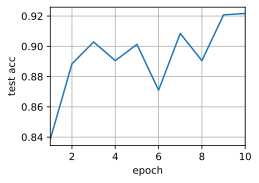

In [6]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

Net we use 2 GPUs for training.

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2)